Linking: https://blog.csdn.net/weixin_44376341/article/details/119956299

使用torchtext处理数据集

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
print("============查看GPU信息================")
# 查看GPU信息
!/opt/bin/nvidia-smi
print("============查看虚拟机硬盘容量================")
# 查看虚拟机硬盘容量
!df -lh
print("============查看cpu配置================")
# 查看cpu配置
!cat /proc/cpuinfo | grep model\ name
print("=============查看内存容量===============")
# 查看内存容量
!cat /proc/meminfo | grep MemTotal

============查看GPU信息================
Thu Mar 30 14:40:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                    

In [3]:
%cd /content/gdrive/MyDrive/LSTM+Self-Attention情感分类
!pwd
!ls

/content/gdrive/MyDrive/LSTM+Self-Attention情感分类
/content/gdrive/MyDrive/LSTM+Self-Attention情感分类
LSTM+Self-Attention情感分类.ipynb  train_data_sentiment.csv


In [14]:
!pip uninstall torchtext

Found existing installation: torchtext 0.8.1
Uninstalling torchtext-0.8.1:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/torchtext-0.8.1.dist-info/*
    /usr/local/lib/python3.9/dist-packages/torchtext/*
Proceed (Y/n)? y
  Successfully uninstalled torchtext-0.8.1


In [15]:
!pip3 install torchtext==0.8.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torchtext-0.8.1-cp39-cp39-manylinux1_x86_64.whl (6.9 MB)


In [4]:
# 导入常用库
import math
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F
import torchtext
from torchtext.vocab import Vectors
# 比较新版本的需要使用torchtext.legacy.data，旧版本的torchtext使用torchtex.data
from torchtext.data import TabularDataset
import warnings
warnings.filterwarnings("ignore")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
#导入数据集
train_data = pd.read_csv('train_data_sentiment.csv')
train_data

,utterance,label
0,also I was the point person on my company’s tr...,0
1,You must’ve had your hands full.,0
2,That I did. That I did.,0
3,So let’s talk a little bit about your duties.,0
4,My duties? All right.,1
...,...,...
9984,You or me?,0
9985,"I got it. Uh, Joey, women don't have Adam's ap...",0
9986,"You guys are messing with me, right?",1
9987,Yeah.,0


In [8]:
# 定义Field
# 这里使用默认分词器split(),按照空格进行分词
TEXT = torchtext.data.Field(sequential=True, lower=True, fix_length=30)
LABEL = torchtext.data.Field(sequential=False, use_vocab=False)


In [9]:
train_x = TabularDataset(path='train_data_sentiment.csv',
                         format='csv', skip_header=True,
                         fields=[('utterance', TEXT), ('label', LABEL)])


In [10]:
#构建词表
TEXT.build_vocab(train_x)  #构建了10440个词，从0-10439
for w,i in TEXT.vocab.stoi.items():
    print(w,i)

流式输出内容被截断，只能显示最后 5000 行内容。
criticism 5440
criticism. 5441
critics 5442
cross-eyed 5443
crossword 5444
crotch 5445
crowd 5446
crowning 5447
cruel 5448
cruel. 5449
cruise? 5450
crumbies! 5451
crumbly, 5452
crushing 5453
crust 5454
crust, 5455
cry? 5456
crying? 5457
crystal 5458
cuba. 5459
cuba? 5460
cubby 5461
cube 5462
cube. 5463
cubicle 5464
cubicle. 5465
cufflinks 5466
cultivating 5467
culture 5468
cup, 5469
cupboard 5470
cupert-hewitt 5471
cups 5472
cups! 5473
cups, 5474
cups? 5475
curiously 5476
curler, 5477
cursed 5478
cursed. 5479
curtain 5480
cushions. 5481
custom-made, 5482
cut, 5483
cut. 5484
cute? 5485
cuter 5486
cuter!! 5487
cutie 5488
cutout 5489
cuts 5490
cuz 5491
cycles, 5492
c’mon 5493
d'know. 5494
d'y'see 5495
d-cup. 5496
d.d.s. 5497
d.j.-ing 5498
dad's 5499
daddy 5500
daddy. 5501
daddy." 5502
daddy? 5503
dad’s 5504
daiquiris. 5505
dakota? 5506
damage 5507
damage. 5508
damaged 5509
dammit, 5510
damnit 5511
damnit, 5512
dan 5513
dana? 5514
danced 5515
dancer! 5516
dancers

In [13]:
#加载glove词向量，第一次使用会自动下载，也可以自己下载好该词向量，我这里用的是400000词，每个词由100维向量表示
TEXT.vocab.load_vectors('glove.6B.100d',unk_init=torch.Tensor.normal_) #将数据中有但glove词向量中不存在的词进行随机初始化分配100维向量

In [15]:
print(TEXT.vocab.vectors.shape) #torch.Size([10440, 100])

torch.Size([10440, 100])


In [16]:
# 创建迭代器
batch_size = 64
train_iter = torchtext.data.Iterator(
    dataset=train_x, batch_size=64, shuffle=True, sort_within_batch=False, repeat=False, device=device)
len(train_iter)  # 157

157

In [17]:
#查看构建的迭代器
list(train_iter)

[
 [torchtext.data.batch.Batch of size 64]
 	[.utterance]:[torch.cuda.LongTensor of size 30x64 (GPU 0)]
 	[.label]:[torch.cuda.LongTensor of size 64 (GPU 0)],
 
 [torchtext.data.batch.Batch of size 64]
 	[.utterance]:[torch.cuda.LongTensor of size 30x64 (GPU 0)]
 	[.label]:[torch.cuda.LongTensor of size 64 (GPU 0)],
 
 [torchtext.data.batch.Batch of size 64]
 	[.utterance]:[torch.cuda.LongTensor of size 30x64 (GPU 0)]
 	[.label]:[torch.cuda.LongTensor of size 64 (GPU 0)],
 
 [torchtext.data.batch.Batch of size 64]
 	[.utterance]:[torch.cuda.LongTensor of size 30x64 (GPU 0)]
 	[.label]:[torch.cuda.LongTensor of size 64 (GPU 0)],
 
 [torchtext.data.batch.Batch of size 64]
 	[.utterance]:[torch.cuda.LongTensor of size 30x64 (GPU 0)]
 	[.label]:[torch.cuda.LongTensor of size 64 (GPU 0)],
 
 [torchtext.data.batch.Batch of size 64]
 	[.utterance]:[torch.cuda.LongTensor of size 30x64 (GPU 0)]
 	[.label]:[torch.cuda.LongTensor of size 64 (GPU 0)],
 
 [torchtext.data.batch.Batch of size 64]
 	[

In [18]:
#查看批数据的大小
for batch in train_iter:
    print(batch.utterance.shape)

torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([30, 64])
torch.Size([3

In [20]:
batch


[torchtext.data.batch.Batch of size 5]
	[.utterance]:[torch.cuda.LongTensor of size 30x5 (GPU 0)]
	[.label]:[torch.cuda.LongTensor of size 5 (GPU 0)]

In [19]:
#查看第一条数据
batch.utterance[:,0]#我们取的是第1列，因为第1列表示第一条数据，即第64列表示第64条数据。每条数据由30个词组成，下面非1部分表示第一条数据中的词在词表中的索引，剩下的1表示补长的部分。

tensor([  42, 1422,   12, 1769,  121,   26,    3,  397,    5, 3315, 2354,  120,
         765,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1], device='cuda:0')

In [21]:
#查看第一条数据中的词所对应的索引值
list_a=[]
for i in batch.utterance[:,0]:
    if i.item()!=1:
        list_a.append(i.item())
print(list_a)
for i in list_a:
    print(TEXT.vocab.itos[i],end=' ')

[42, 1422, 12, 1769, 121, 26, 3, 397, 5, 3315, 2354, 120, 765]
well, lots of people! look, are you coming to memorial service or not? 

In [25]:
#查看迭代器中的数据及其对应的文本
l =[]
for batch in list(train_iter)[:1]:
    for i in batch.utterance:
        l.append(i[0].item())
    print(l)
    print(' '.join([TEXT.vocab.itos[i] for  i in l]))

[246, 71, 3, 215, 170, 10, 85, 116, 29, 210, 291, 5, 148, 29, 300, 8, 2, 110, 418, 23, 316, 171, 7725, 1, 1, 1, 1, 1, 1, 1]
what, did you actually thought it would make me feel better to give me stuff that i can’t use for another two months?! <pad> <pad> <pad> <pad> <pad> <pad> <pad>


搭建LSTM+Self-Attention网络模型

- vocab_size: 构建的词表中的词数
- embedding_size: 每个词的词向量维度
- hidden_dim：LSTM中隐藏层的单元个数
- n_layers：LSTM中的隐藏层数量
- num_class：类别数

In [26]:
vocab_size = 10440
embedding_size = 100
hidden_dim = 128
n_layers = 1
num_class = 3

In [44]:
class LSTM_Attention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, num_class):
        super(LSTM_Attention, self).__init__()

        # 从LSTM得到output之后，将output通过下面的linear层，然后就得到了Q,K,V
        # 这里我是用的attention_size是等于hidden_dim的，这里可以自己换成别的attention_size
        self.W_Q = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.W_K = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.W_V = nn.Linear(hidden_dim, hidden_dim, bias=False)

        # embedding层
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM
        self.rnn = nn.LSTM(input_size=embedding_dim,
                           hidden_size=hidden_dim, num_layers=n_layers)
        # Linear层,因为是三分类，所以后面的维度为3
        self.fc = nn.Linear(hidden_dim, num_class)
        # dropout
        self.dropout = nn.Dropout(0.5)

    # 用来计算attention
    def attention(self, Q, K, V):

        d_k = K.size(-1)
        scores = torch.matmul(Q, K.transpose(1, 2)) / math.sqrt(d_k)
        alpha_n = F.softmax(scores, dim=-1)
        context = torch.matmul(alpha_n, V)

        # 这里都是组合之后的矩阵之间的计算，所以.sum之后，得到的output维度就是[batch_size,hidden_dim]，并且每一行向量就表示一句话，所以总共会有batch_size行
        output = context.sum(1)

        return output, alpha_n

    def forward(self, x):
        #x.shape = [seq_len,batch_size] = [30,64]

        # embedding.shape = [seq_len,batch_size,embedding_dim = 100]
        embedding = self.dropout(self.embedding(x))
        # embedding.shape = [batch_size,seq_len,embedding_dim]
        embedding = embedding.transpose(0, 1)
        # 进行LSTM
        # out.shape = [batch_size,seq_len,hidden_dim=128]
        output, (h_n, c) = self.rnn(embedding)

        Q = self.W_Q(output)  # [batch_size,seq_len,hidden_dim]
        K = self.W_K(output)
        V = self.W_V(output)

        # 将得到的Q，K，V送入attention函数进行运算
        attn_output, alpha_n = self.attention(Q, K, V)
        # attn_output.shape = [batch_size,hidden_dim=128]
        #alpha_n.shape = [batch_size,seq_len,seq_len]

        out = self.fc(attn_output)  # out.shape = [batch_size,num_class]
        return out


In [45]:
# 看一下我们搭建的网络模型
net = LSTM_Attention(vocab_size=vocab_size, embedding_dim=embedding_size,
                     hidden_dim=hidden_dim, n_layers=n_layers, num_class=num_class).to(device)
net


LSTM_Attention(
  (W_Q): Linear(in_features=128, out_features=128, bias=False)
  (W_K): Linear(in_features=128, out_features=128, bias=False)
  (W_V): Linear(in_features=128, out_features=128, bias=False)
  (embedding): Embedding(10440, 100)
  (rnn): LSTM(100, 128)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [46]:
TEXT.vocab.vectors.size()

torch.Size([10440, 100])

模型训练及结果

In [47]:
net.embedding.weight.data.copy_(TEXT.vocab.vectors)  # 给模型的Embedding层传入我们的词嵌入矩阵
optimizer = optim.Adam(net.parameters(), lr=1e-3)  # 定义优化器，lr是学习率可以自己调
criterion = nn.CrossEntropyLoss().to(device)  # 定义损失函数
train_x_len = len(train_x)  # 这一步是我为了计算后面的Acc而获取的数据数量，也就是9989
train_x_len

9989

In [48]:
# 定义训练函数
def train(net, iterator, optimizer, criterion, train_x_len):
    epoch_loss = 0  # 初始化loss值
    epoch_acc = 0  # 初始化acc值
    for batch in iterator:
        optimizer.zero_grad()  # 梯度清零
        preds = net(batch.utterance)  # 前向传播，求出预测值
        loss = criterion(preds, batch.label)  # 计算loss
        epoch_loss += loss.item()  # 累加loss，作为下面求平均loss的分子
        loss.backward()  # 反向传播
        optimizer.step()  # 更新网络中的权重参数
        epoch_acc += ((preds.argmax(axis=1)) ==
                      batch.label).sum().item()  # 累加acc，作为下面求平均acc的分子
    return epoch_loss/(len(iterator)), epoch_acc/train_x_len  # 返回的是loss值和acc值


In [49]:
n_epoch = 100
acc_plot = []  # 用于后面画图
loss_plot = []  # 用于后面画图
for epoch in range(n_epoch):
    train_loss, train_acc = train(
        net, train_iter, optimizer, criterion, train_x_len)
    acc_plot.append(train_acc)
    loss_plot.append(train_loss)
    if (epoch+1) % 10 == 0:
        print('epoch: %d \t loss: %.4f \t train_acc: %.4f' %
              (epoch+1, train_loss, train_acc))


epoch: 10 	 loss: 0.7920 	 train_acc: 0.6582
epoch: 20 	 loss: 0.5965 	 train_acc: 0.7524
epoch: 30 	 loss: 0.4756 	 train_acc: 0.8060
epoch: 40 	 loss: 0.4018 	 train_acc: 0.8424
epoch: 50 	 loss: 0.3532 	 train_acc: 0.8567
epoch: 60 	 loss: 0.3149 	 train_acc: 0.8739
epoch: 70 	 loss: 0.2873 	 train_acc: 0.8855
epoch: 80 	 loss: 0.2677 	 train_acc: 0.8932
epoch: 90 	 loss: 0.2475 	 train_acc: 0.9013
epoch: 100 	 loss: 0.2346 	 train_acc: 0.9073


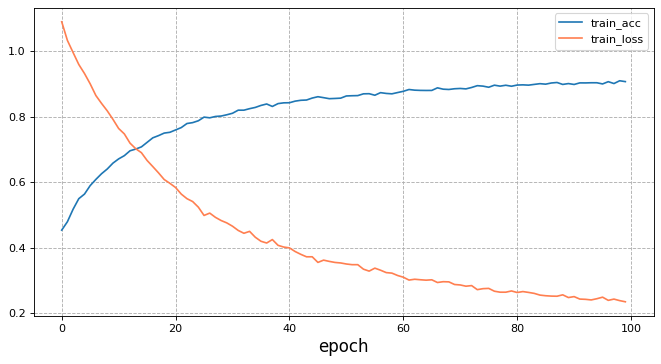

In [50]:
# 使用画图函数matplotlib
plt.figure(figsize=(10, 5), dpi=80)
plt.plot(acc_plot, label='train_acc')
plt.plot(loss_plot, color='coral', label='train_loss')
plt.legend(loc=0)
plt.grid(True, linestyle='--', alpha=1)
plt.xlabel('epoch', fontsize=15)
plt.show()
